### Imports

In [141]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Loading data

In [159]:
# File paths from user-uploaded data
mat_file_path = "./data/student-mat.csv"
por_file_path = "./data/student-por.csv"

# Reading the CSV files
student_mat = pd.read_csv(mat_file_path, sep=';')
student_por = pd.read_csv(por_file_path, sep=';')

# Reset the index of each DataFrame before concatenation
student_mat.reset_index(drop=True, inplace=True)
student_por.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
df = pd.concat([student_mat, student_por], ignore_index=True)

df = pd.get_dummies(df, columns=[ "Mjob", "Fjob", "reason", "guardian","school", "sex", "address", "famsize", "Pstatus" ]) #one hot encoder
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print(f"Mapping: {col}", mapping)


Mapping: schoolsup {'no': 0, 'yes': 1}
Mapping: famsup {'no': 0, 'yes': 1}
Mapping: paid {'no': 0, 'yes': 1}
Mapping: activities {'no': 0, 'yes': 1}
Mapping: nursery {'no': 0, 'yes': 1}
Mapping: higher {'no': 0, 'yes': 1}
Mapping: internet {'no': 0, 'yes': 1}
Mapping: romantic {'no': 0, 'yes': 1}


### Loading the model from part 1

R² Score: 0.77984893632158


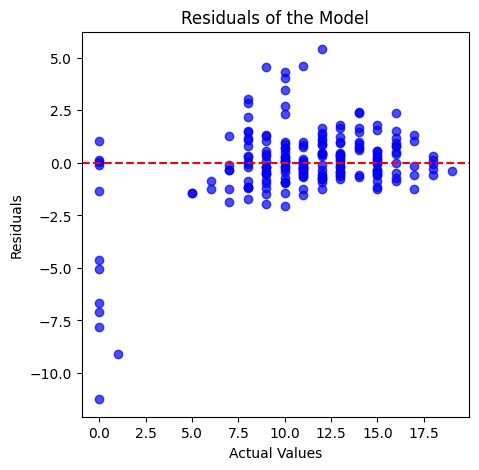

In [136]:
# Prepare the data
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")
residuals = y_test - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(y_test, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [102]:
# Add residuals to the test set for analysis
test_set_with_residuals = X_test.copy()
test_set_with_residuals['Actual'] = y_test
test_set_with_residuals['Predicted'] = y_pred
test_set_with_residuals['Residual'] = test_set_with_residuals['Actual'] - test_set_with_residuals['Predicted']


# Sort by largest residuals (absolute errors)
test_set_with_residuals['AbsoluteError'] = test_set_with_residuals['Residual'].abs()
filtered_data = test_set_with_residuals[test_set_with_residuals['Actual'] > 0]
worst_performance = filtered_data.sort_values(by='AbsoluteError', ascending=False).head(10)

worst_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=False).head(10)
best_performance = test_set_with_residuals.sort_values(by='AbsoluteError', ascending=True).head(10)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
worst_performance

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Actual,Predicted,Residual,AbsoluteError
558,18,1,1,1,1,2,0,0,0,0,1,0,1,1,2,3,5,2,5,4,0,11,9,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,True,False,True,0,11.245638,-11.245638,11.245638
567,16,3,3,1,2,1,0,1,0,0,1,1,1,1,4,5,5,4,4,5,0,10,10,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,True,True,False,False,True,1,10.095816,-9.095816,9.095816
310,19,1,2,1,2,1,0,0,0,1,0,1,0,1,4,2,4,2,2,3,0,9,9,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,True,False,True,False,False,True,False,True,False,True,0,7.792034,-7.792034,7.792034
296,19,4,4,2,2,0,0,1,1,1,1,1,1,0,2,3,4,2,3,2,0,10,9,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,True,False,False,True,True,False,False,True,0,7.087438,-7.087438,7.087438
168,16,2,2,1,2,0,0,1,1,0,0,1,1,0,5,1,5,1,1,4,0,6,7,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,0,6.668687,-6.668687,6.668687
784,18,2,2,1,2,0,0,0,0,1,0,1,1,1,4,3,3,1,1,2,0,10,9,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,True,False,False,True,False,True,False,True,12,6.593416,5.406584,5.406584
978,18,2,2,2,1,1,0,0,0,0,1,0,1,1,5,5,5,1,1,3,0,8,6,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,0,5.027615,-5.027615,5.027615
745,19,2,1,2,3,1,0,0,0,1,1,1,1,1,4,3,1,1,1,5,0,9,10,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,True,False,True,11,6.372767,4.627233,4.627233
333,18,2,2,1,2,0,0,0,0,1,0,1,1,1,4,3,3,1,1,2,0,8,8,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,True,False,False,True,False,True,False,True,0,4.613390,-4.613390,4.613390
1019,17,1,1,3,1,1,0,1,0,0,1,1,1,1,5,2,1,1,2,1,0,8,8,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,True,False,False,True,9,4.455048,4.544952,4.544952


# 1. Error Analysis Conclusions & work plan

To enhance our initial baseline model, we recommend two key improvements:

### 1.1. Implement k-fold cross-validation
This technique will refine our model evaluation by using various subsets of the data for training and testing, ensuring a comprehensive assessment that isn't skewed by specific data segments.

### 1.2. Introduce a `G3_is_zero` feature
Our analysis indicates numerous instances in the `worst_performance` category where `G3` equals zero, despite non-zero `G1` and `G2` scores. This suggests that the model may be relying heavily on `G1` and `G2` but failing to accurately predict cases where `G3` deviates to zero. By creating a boolean feature to flag these cases, the model can better identify and manage these outliers, thus improving both accuracy and generalization.

### 1.3. Conduct feature selection
We will perform feature selection to identify which features contribute most significantly to predicting outcomes. This step will help streamline our model, ensuring only the most impactful features are used, enhancing model efficiency and potentially improving performance.

### 1.4. Create a new feature: `average_G1_G2`
We will create a new column that represents the average of `G1` and `G2` scores. This new feature could provide a more stable basis for predicting `G3`, reflecting overall performance prior to the final grade.

# 2. Improving Model Performance

### Implement k-fold cross-validation 

In [137]:

# Prepare the data
X = df.drop(columns=['G3'])  # Features
y = df['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_x_vals = []  # List to store all x_val DataFrames/Series from each fold
all_y_vals = []  # List to store all y_val DataFrames/Series from each fold

# To store scores for each fold
scores = []
# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    all_x_vals.append(X_val)  # Append current y_val to the list
    all_y_vals.append(y_val)  # Append current y_val to the list
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    score = model.score(X_val, y_val)  
    scores.append(score)

# Print the average score across all folds
print("Average model performance:", np.mean(scores))


Average model performance: 0.8028214870340822


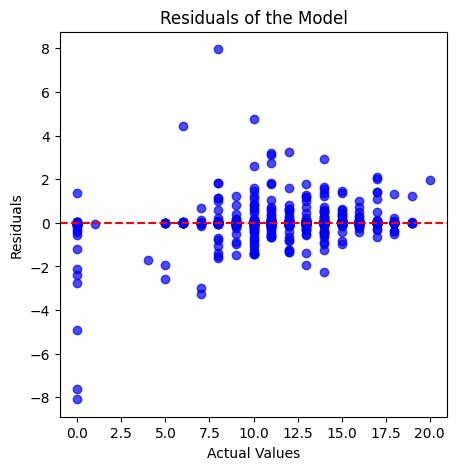

In [110]:
# Visualize residuals
combined_x_val = pd.concat(all_x_vals, ignore_index=True)
combined_y_val = pd.concat(all_y_vals, ignore_index=True)
y_pred = model.predict(combined_x_val)

residuals = combined_y_val - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(combined_y_val, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

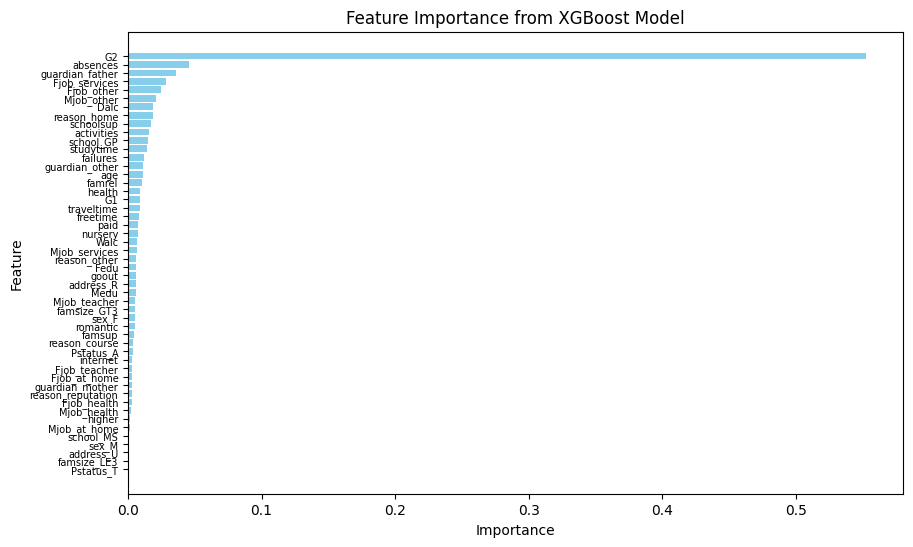

In [108]:
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.title("Feature Importance from XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Optionally, to change the font size of the tick labels on the y-axis
plt.gca().tick_params(axis='y', labelsize=7)  # Set font size for y-axis tick labels

plt.show()

### Introduce a `G3_is_zero` feature

In [138]:

# Filter out rows where 'absences' is 0 and 'G3' is 0
df_with_is_zero = df.copy()
df_with_is_zero['G3_is_zero'] = df_with_is_zero['G3'] == 0

X = df_with_is_zero.drop(columns=['G3'])  # Features
y = df_with_is_zero['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_x_vals = []  # List to store all x_val DataFrames/Series from each fold
all_y_vals = []  # List to store all y_val DataFrames/Series from each fold

# To store scores for each fold
scores = []
# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    all_x_vals.append(X_val)  # Append current y_val to the list
    all_y_vals.append(y_val)  # Append current y_val to the list
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    score = model.score(X_val, y_val)  # R^2 score, but you can choose another metric
    scores.append(score)

# Print the average score across all folds
print("Average model performance:", np.mean(scores))


Average model performance: 0.9278747919711032


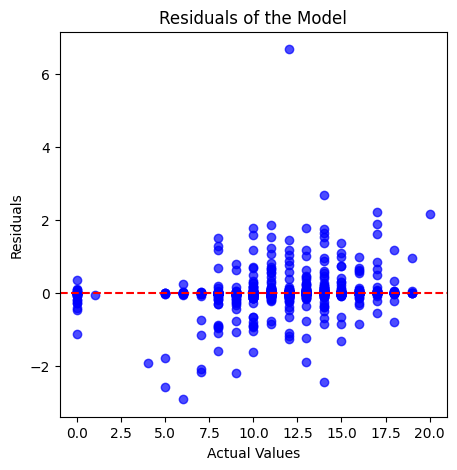

In [120]:
# Visualize residuals
combined_x_val = pd.concat(all_x_vals, ignore_index=True)
combined_y_val = pd.concat(all_y_vals, ignore_index=True)
y_pred = model.predict(combined_x_val)

residuals = combined_y_val - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(combined_y_val, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

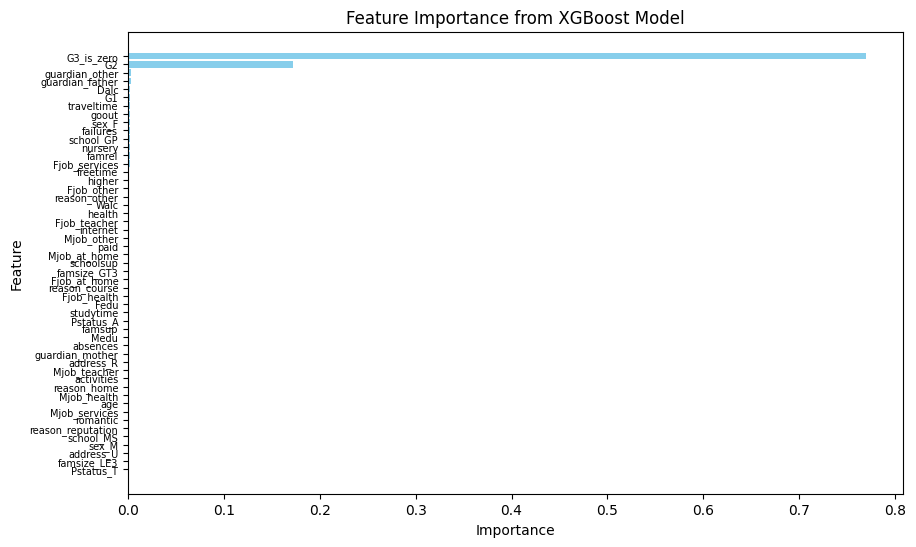

In [139]:
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.title("Feature Importance from XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Optionally, to change the font size of the tick labels on the y-axis
plt.gca().tick_params(axis='y', labelsize=7)  # Set font size for y-axis tick labels

plt.show()

### Create a new feature: `average_G1_G2`

In [140]:

# Filter out rows where 'absences' is 0 and 'G3' is 0
df_with_is_zero = df.copy()
df_with_is_zero['G3_is_zero'] = df_with_is_zero['G3'] == 0
df_with_is_zero['average_G1_G2'] = (df['G1'] + df['G2'])/2
X = df_with_is_zero.drop(columns=['G3'])  # Features
y = df_with_is_zero['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_x_vals = []  # List to store all x_val DataFrames/Series from each fold
all_y_vals = []  # List to store all y_val DataFrames/Series from each fold

# To store scores for each fold
scores = []
# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    all_x_vals.append(X_val)  # Append current y_val to the list
    all_y_vals.append(y_val)  # Append current y_val to the list
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    score = model.score(X_val, y_val)  # R^2 score, but you can choose another metric
    scores.append(score)

# Print the average score across all folds
print("Average model performance:", np.mean(scores))


Average model performance: 0.9260410216543484


### Hyperparameter tuning

In [142]:

# Filter out rows where 'absences' is 0 and 'G3' is 0
df_with_is_zero = df.copy()
df_with_is_zero['G3_is_zero'] = df_with_is_zero['G3'] == 0

X = df_with_is_zero.drop(columns=['G3'])  # Features
y = df_with_is_zero['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kf, verbose=1)

# Perform Grid Search
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Optionally, you can use the best model found for further predictions
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best cross-validation score: 0.94


### Feature engineering (creating new features,transforming existing ones).

In [161]:
df['avg_G1_G2'] = df[['G1', 'G2']].mean(axis=1)
# df['parent_job'] = df['Mjob'] + "_" + df['Fjob']
# df['age_group'] = pd.cut(df['age'], bins=[10, 14, 16, 18, 20], labels=['10-14', '15-16', '17-18', '19-20'])

# Filter out rows where 'absences' is 0 and 'G3' is 0
df_with_is_zero = df.copy()
df_with_is_zero['G3_is_zero'] = df_with_is_zero['G3'] == 0
X = df_with_is_zero.drop(columns=['G3'])  # Features
y = df_with_is_zero['G3']  # Target

# Set up the model
model = XGBRegressor(random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
all_x_vals = []  # List to store all x_val DataFrames/Series from each fold
all_y_vals = []  # List to store all y_val DataFrames/Series from each fold

# To store scores for each fold
scores = []
# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    all_x_vals.append(X_val)  # Append current y_val to the list
    all_y_vals.append(y_val)  # Append current y_val to the list
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    score = model.score(X_val, y_val)  # R^2 score, but you can choose another metric
    scores.append(score)

# Print the average score across all folds
print("Average model performance:", np.mean(scores))


# from sklearn.feature_selection import SelectFromModel
# selector = SelectFromModel(estimator=XGBRegressor()).fit(X, y)
# X_selected = selector.transform(X)


Average model performance: 0.9260410216543484


### Balancing data

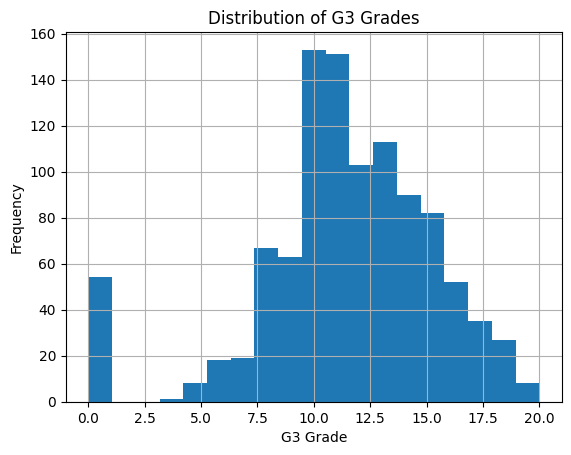

Skewness of G3: -0.9859646596265084
Kurtosis of G3: 1.7443194752957858


In [145]:
import matplotlib.pyplot as plt

# Plotting the distribution of G3 grades
df['G3'].hist(bins=len(df['G3'].unique()))
plt.title('Distribution of G3 Grades')
plt.xlabel('G3 Grade')
plt.ylabel('Frequency')
plt.show()
print("Skewness of G3:", df['G3'].skew())
print("Kurtosis of G3:", df['G3'].kurtosis())
